In [47]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS

import os, sys
sys.path.append('/home/jiaxuanl/Research/SALAD/script/')
import kuaizi
from kuaizi.display import display_single
kuaizi.set_env(project='SBF', name='Rosesim', data_dir='/scratch/gpfs/JENNYG/jiaxuanl/Data')
# kuaizi.set_matplotlib(style='JL', usetex=True, fontsize=18, figsize=(7, 5), dpi=90)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/Rosesim'

In [48]:
import asdf
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table, vstack, Column, hstack
from astropy import units as u
from astropy.visualization import simple_norm
import copy
import galsim
import roman_datamodels as rdm
from romanisim import gaia, bandpass, catalog, log, wcs, persistence, parameters, ris_make_utils as ris
from romanisim.image import inject_sources_into_l2
from romanisim.l3 import inject_sources_into_l3

In [144]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = "30"
import artpop
sys.path.append('/home/jiaxuanl/Research/SBF/src/SBF')
import rosesim
from rosesim import RomanGalaxy, RomanSky, rng

## Now we already have a sky. How to include the sky into RomanGal??

In [229]:
obs_ra = 150.1049 #270.95
obs_dec = 2.2741 # -0.2
# obs_dec = 2.2832743

## Now load a Roman galaxy

In [230]:
log_m_star = 6
gal_kwargs = {'age': 0.4 * u.Gyr,
              'feh': -1.5,
              'total_mass': 10**log_m_star,
              'r_eff': 10**rosesim.mass_size_carlsten(log_m_star) / 1000 * u.kpc,
              'distance': 20 * u.Mpc}
gal = RomanGalaxy(prefix=f'ufd_1e{log_m_star}_{int(gal_kwargs["distance"].to(u.Mpc).value)}Mpc_{gal_kwargs["age"].value}Gyr')
reff = (gal_kwargs['r_eff'] / gal_kwargs['distance']).cgs.value * 206265
print('R_eff [arcsec]', reff)
print('15 R_eff [pix]', reff / 0.11 * 15)
s = int(reff / rosesim.pixel_scale * 15)
s = s + (s+1) % 2

dmod = 5 * np.log10(gal_kwargs['distance'].value) + 25
mag_lim = dmod - 1
print('mag lim', mag_lim)

R_eff [arcsec] 3.6846440980703794
15 R_eff [pix] 502.4514679186881
mag lim 30.505149978319906


In [231]:
src = artpop.MISTSersicSSP(
    log_age=np.log10(gal_kwargs['age'].to(u.yr).value),        # log of age in years
    feh=gal_kwargs['feh'],           # metallicity [Fe/H]
    r_eff=gal_kwargs['r_eff'],
    n=0.8, theta=100 * u.deg, ellip=0.3,
    total_mass=gal_kwargs['total_mass'],
    mag_limit=mag_lim,
    mag_limit_band='H158',
    phot_system='WFIRST', # in vega
    distance=gal_kwargs['distance'],
    xy_dim=s, 
    pixel_scale=rosesim.pixel_scale,
    random_state=rng,
)
print('# of stars', src.num_stars)
print('Sampled mass fraction:', src.sp.sampled_mass / src.sp.total_mass)
# convert Vega to AB
for filt in src.mags.colnames:
    src.mags[filt] += rosesim.Roman_zp_AB_Vega_mist[filt]

print('Total mag from stars', -2.5 * np.log10(np.sum(10**(-0.4 * src.mags['H158']))))
print('Total mag fron smooth', src.sp.mag_integrated_component('H158'))
print('SB of smooth', src.sp.mag_integrated_component('H158') + 2.5 * np.log10(2 * np.pi * src.smooth_model.r_eff.value**2 * 0.11**2))

# of stars 7144
Sampled mass fraction: 0.018194004618216818
Total mag from stars 20.099425986461718
Total mag fron smooth 20.366505694133703
SB of smooth 25.193931052360405


In [252]:
gal.load_src(src, ra=obs_ra, dec=obs_dec)
gal.gen_catalog()

Catalogue generated.


In [253]:
gal.obj_cat = gal.obj_cat[:]

In [254]:
# for filt in ['F129', 'F158', 'F106']:
for filt in ['F158']:
    gal.load_bkg(filt, f'/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/Rosesim/sky_jaguar/{filt}_642s.asdf')
    gal.observe(exptimes=642)
    gal.dm.save(f'./{filt}_642s.asdf')

Loaded background from /scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/Rosesim/sky_jaguar/F158_642s.asdf


2025-08-13 03:16:36 INFO     Setting pixscale to match default.
2025-08-13 03:16:36 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2025-08-13 03:16:36 INFO     Using pupil mask 'F062' and detector 'WFI01'.
2025-08-13 03:16:36 INFO     Using pupil mask 'F062' and detector 'WFI02'.
2025-08-13 03:16:36 INFO     Using pupil mask 'F158' and detector 'WFI02'.
2025-08-13 03:16:36 INFO     No source spectrum supplied, therefore defaulting to 5700 K blackbody
2025-08-13 03:16:36 INFO     Computing wavelength weights using synthetic photometry for F158...
2025-08-13 03:16:36 INFO     Using pupil mask 'F158' and detector 'WFI02'.
2025-08-13 03:16:36 INFO     PSF calc using fov_arcsec = 5.000000, oversample = 4, number of wavelengths = 10
2025-08-13 03:16:36 INFO     Creating optical system model:
2025-08-13 03:16:36 INFO     Initialized OpticalSystem: Roman+WFI
2025-08-13 03:16:37 INFO     Roman Entrance Pupil: Loaded amplitude transmission from /home/jiaxuanl/data/stpsf-data/W

In [241]:
import warnings
from copy import deepcopy
import astrocut
from astrocut import get_center_pixel, ASDFCutout
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

from display import show_image_wcs

In [255]:
asdf_cutout = ASDFCutout("./F158_642s.asdf", 
                         SkyCoord(obs_ra, obs_dec, unit='deg'), 
                         500)

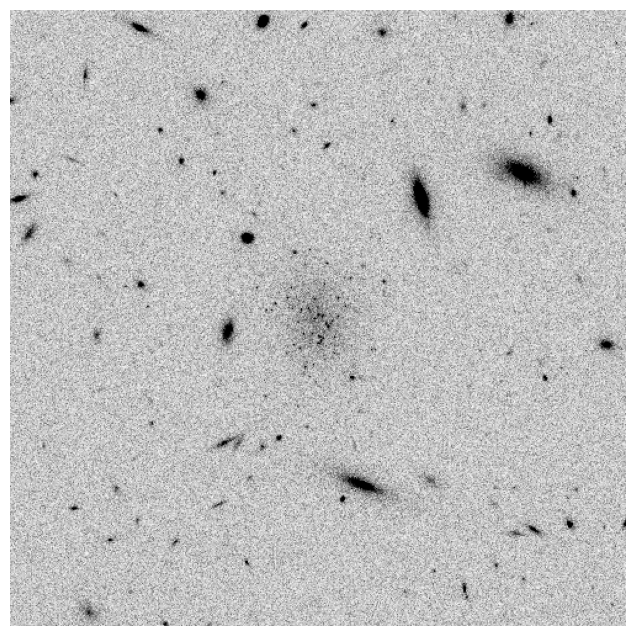

In [256]:
img = asdf_cutout.cutouts[0].data 
display_single(img - np.median(img), cmap='Greys', scale_bar=False);

In [162]:
rosesim.asdf_to_fits(gal.dm, f'{filt}_642s.fits', subtract_bkg=True)

Successfully wrote FITS file: F158_642s.fits


# Visualize

In [163]:
from astropy.visualization import make_lupton_rgb

In [164]:
zp = -2.5 * np.log10(1 * ((0.11 * u.arcsec)**2).to(u.steradian).value * 1e6 / 3631)

In [226]:
prefix = 'ufd_1e6_25Mpc_1.0Gyr'
prefix = 'dw_1e5.5_20Mpc_1.0Gyr'
# prefix = 'dw_1e4.5_3Mpc_1.0Gyr'

In [227]:
filters = ['F106', 'F129', 'F158']
imgs = []
for filt in filters:
    asdf_cutout = ASDFCutout(f"/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/Rosesim/{prefix}/{filt}_642s.asdf", 
                             SkyCoord(obs_ra, obs_dec, unit='deg'), 2000)

    hdu = asdf_cutout.fits_cutouts[0]
    hdu.writeto(f'/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/Rosesim/{prefix}/{filt}_642s_cutout.fits', overwrite=True)

    img = asdf_cutout.cutouts[0].data
    img -= np.median(img)
    img *= 10**(0.4 * (27 - zp))
    # imgs.append(img[250:1250, :])
    imgs.append(img[:, :])

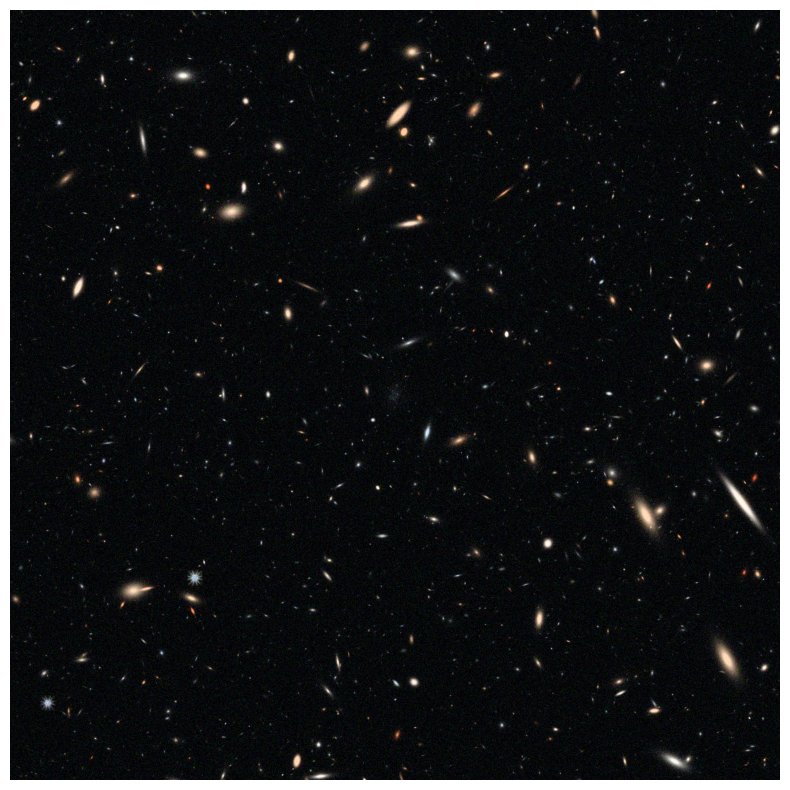

In [228]:
rgb = make_lupton_rgb(0.9 * imgs[2], 1.05 * imgs[1], 1.2 * imgs[0], minimum=0, stretch=1, Q=3)
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(rgb)
plt.axis('off')

# plt.text(wid - 0.2 * wid, +5, filters[filt_idx[0]], 
         # fontsize=20, color='deepskyblue', va='center', ha='center')
# plt.text(wid, +5, filters[filt_idx[1]], 
         # fontsize=20, color='limegreen', va='center', ha='center')
# plt.text(wid + 0.2 * wid, +5, filters[filt_idx[2]], 
         # fontsize=20, color='orangered', va='center', ha='center')
# title = prefix
# plt.title(title, fontsize=20)

plt.savefig(f'/tigress/jiaxuanl/public_html/figure/SBF/Rosesim/{prefix}.png', bbox_inches='tight', dpi=200, transparent=True)

----

## Image gallery

In [275]:
for mass in [5.5, 6, 6.5, 7]:
    for dist in [50]:
        prefix = f'dw_1e{mass:.1f}_{int(dist)}Mpc_1.0Gyr'
    
        filters = ['F106', 'F129', 'F158']
        imgs = []
        for filt in filters:
            asdf_cutout = ASDFCutout(f"/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/Rosesim/{prefix}/{filt}_642s.asdf", 
                                     SkyCoord(obs_ra, obs_dec, unit='deg'), 300)
        
            hdu = asdf_cutout.fits_cutouts[0]
            hdu.writeto(f'/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/Rosesim/{prefix}/{filt}_642s_cutout.fits', overwrite=True)
        
            img = asdf_cutout.cutouts[0].data
            img -= np.median(img)
            img *= 10**(0.4 * (27 - zp))
            imgs.append(img[:, :])
    
        rgb = make_lupton_rgb(0.9 * imgs[2], 1.05 * imgs[1], 1.2 * imgs[0], minimum=0, stretch=1, Q=3)
        fig, ax = plt.subplots(figsize=(10, 10))
        plt.imshow(rgb)
        plt.axis('off')
        plt.savefig(f'/tigress/jiaxuanl/public_html/figure/SBF/Rosesim/{prefix}.png', bbox_inches='tight', dpi=200, transparent=True)
        plt.close()

In [ ]:
from PIL import Image

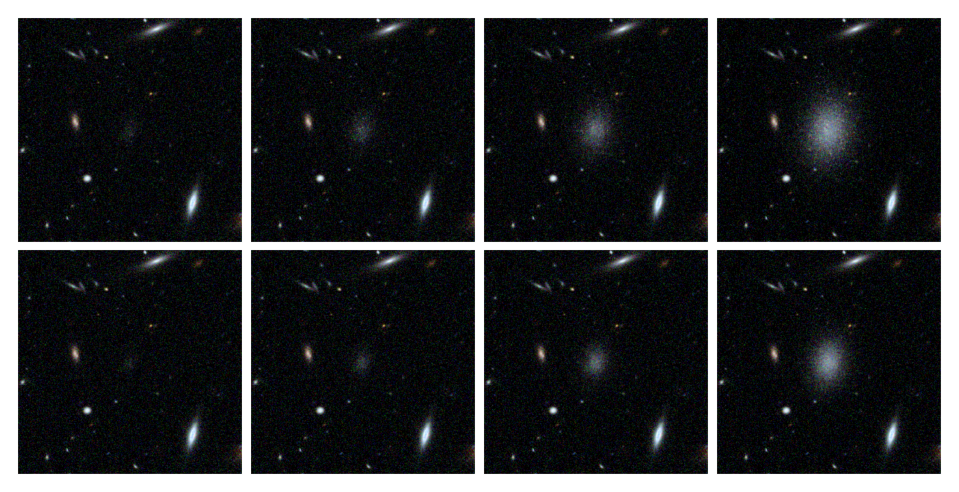

In [280]:
fig, axes = plt.subplots(2, 4, figsize=(4*2, 2*2), dpi=150)
# for ax in axes.flatten():
    # ax.axis('off')
for i, mass in enumerate([5.5, 6, 6.5, 7]):
    for j, dist in enumerate([35, 50]):
        prefix = f'dw_1e{mass:.1f}_{int(dist)}Mpc_1.0Gyr'
        file = f'/tigress/jiaxuanl/public_html/figure/SBF/Rosesim/{prefix}.png'

        ax = axes[j, i]
        image = Image.open(file)
        ax.imshow(image, origin='upper')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        # ax.text(0.05, 0.05, f'{obj['name']}', transform=ax.transAxes, ha='left', color='gray', fontsize=10)
        # ax.text(0.95, 0.85, f'{obj['stage']}', transform=ax.transAxes, ha='right', color='w', fontsize=12)
        # ax.text(0.95, 0.05, f'z={obj['z']:.4f}', transform=ax.transAxes, ha='right', color='w', fontsize=10)

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig(f'/tigress/jiaxuanl/public_html/figure/SBF/Rosesim/summary.png', bbox_inches='tight', transparent=True, dpi=200)